# Adam's batch reduction testing routines

Last updated 13 February 2022

## Goals:
### Test pyspextool components (test data):
* reduction of spex prism point source & extended source
 - status: not yet developed
* reduction of spex SXD point source & extended source
 - status: not yet developed
* reduction of spex LXD point source & extended source
 - status: not yet developed
* reduction of uspex prism point source & extended source
 - status: not yet developed
* reduction of uspex SXD point source & extended source
 - status: **PS proceeds to extraction, XS proceeds to extraction, no 2D yet**
* reduction of uspex LXD point source & extended source
 - status: not yet developed

### Develop functions for batch data preparation
* Legacy data organization by night/PI
 - status: preliminary script for spex data functioning, 2001-2004 organized; uspex data not yet developed
* IRSA data organization by night/PI
 - status: not yet developed
* Generation of log file
 - status: completed for spex data; uspex data not yet developed
* Organization of observations (science targets, calibration targets, source information)
 - status: preliminary script for spex data functioning; uspex data not yet developed
* Generation of batch driving script
 - status: preliminary script for spex data functioning; uspex data not yet developed

### Develop functions for reduced data QA organization
* Organizing and plotting of reduced data
 - status: preliminary script for spex data functioning; uspex data not yet developed
* Organizing of QA information
 - status: not yet developed
* Web portal for review
 - status: preliminary scripts, organization needs further thought

### Conduct batch reduction
* Reduced Legacy data
 - status: not yet begun
* Reduced IRSA data
 - status: not yet begun

### Organization of final data products
* Data organized for integration into SIMPLE database
 - status: not yet begun
* Data organized for integration into IRSA database
 - status: not yet begun

 
 

In [77]:
# Imports and additional functions
import pyspextool as ps
import glob
import numpy
import matplotlib.pyplot as plt
from astropy.io import fits
%matplotlib inline

# Function to read in output spectraN.fits file for xs in A-sky mode 
# data format is [# apertures x # orders, wave/flx/unc/back, column]
# returns wave, flux, unc(?), flags(?)
# NOT NEEDED NOW?

def tmp_read_file(file,order,mode='A-B'):
    hdu = fits.open(file)
    data = hdu[0].data
    header = hdu[0].header # return this?
    hdu.close()
    orders = header['ORDERS'].split(',')
    orders = [int(x) for x in orders]
    if order > numpy.nanmax(orders) or order < numpy.nanmin(orders):
        raise ValueError('Input order {} is not in range of obtained orders {}'.format(order,orders))
    if mode=='A-B' or mode=='A':
        iref = orders.index(order)
        wave = data[iref,0,:]
        flux = data[iref,1,:]
        unc = data[iref,2,:]
        flags = data[iref,3,:]
    else:
        raise ValueError('cannot yet read in mode {}'.format(mode))
#     elif mode=='xs':
#         iref = orders.index(order)
#         wave = data[2*iref,0,:]
#         flux = data[2*iref,1,:]-data[2*iref+1,1,:]
#         unc = (0.5*(data[2*iref,2,:]**2+data[2*iref+1,2,:]**2))**0.5
#         flags = data[2*iref,3,:]
    return wave, flux, unc, flags
    

# pyspextool component testing

Download test data files from https://splat.physics.ucsd.edu/downloads/pyspextool/
and place in a folder where you can read/write

Currently only the uspex-SXD data is functional

## uspex SXD data test

### set up parameters

In [17]:
# set default pathways
instrument = 'uspex'
raw_path = '/Users/adam/projects/spex_archive/testdata_uspex-SXD/'
cal_path = '/Users/adam/projects/spex_archive/test_uspex-SXD/'
proc_path = '/Users/adam/projects/spex_archive/test_uspex-SXD/'
qa_path = '/Users/adam/projects/spex_archive/test_uspex-SXD/'

ps.set_instrument(instrument)
ps.set_paths(raw_path=raw_path, cal_path=cal_path, proc_path=proc_path, qa_path=qa_path)

src_prefix = 'spc-' # science file prefix
flat_prefix = 'flat-' # flat file prefix
arc_prefix = 'arc-' # arc file prefix

flat_files = '18-21' # flat file number(s)
arc_files = '22' # arc file number(s)
src_files = '1-2' # science file numbers
tell_files = '' # telluric file numbers - NOT IN THIS TEST DATA SET

orders = '3-9' # orders to extract
source_type = 'ps' # source type: 'ps' (default) or 'xs'
reduction_mode = 'A-B' # reduction mode: 'A-B' (default), 'A', 'A-Sky/Dark'
aperture_positions = [3.7, 11.2] # preset aperture positions
aperture_method = 'guess' # method to identify aperture: 'fixed', 'guess', or 'auto' (default)
ps_aperture = 1.5 # preset aperture width for point source in multiples of PSF radius
psf_radius = 1.5 # point source PSF radius
ps_bg_parameters = [2.5,4] # point source background parameters; radius to start, then width

xs_aperture = [3,3] # extended source aperture, one per source extracted
xs_bg_regions = [[0.5,2.],[12.5,14]] # extended source background apertures in pixels specifying left and right



Pyspextool Setup
----------------
Instrument:  uspex

Rawpath:  /Users/adam/projects/spex_archive/testdata_uspex-SXD
Calpath:  /Users/adam/projects/spex_archive/test_uspex-SXD
Procpath:  /Users/adam/projects/spex_archive/test_uspex-SXD
Qapath:  /Users/adam/projects/spex_archive/test_uspex-SXD

QA Extension: .pdf
----------------



### Flat and wavecal files

 
Creating the flat field...
Loading FITS images...
Scaling images...
Medianing the images...
Locating the orders...
Normalizing the median image...
Writing flat to disk...
float64
float64
int64
Flat field flat18-21.fits written to disk.
 
Creating the wavecal file...
Loading FITS images...
Extracting 1 apertures in 7 orders (without background subtraction)...
100% |**********************************************************************|
Finding the lines...


/Users/adam/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


100% |**********************************************************************|
Determining the wavelength solution...
Writing wavecal to disk...


Wavecal wavecal22.fits written to disk.


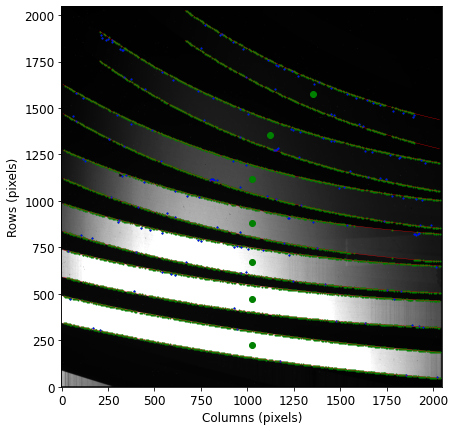

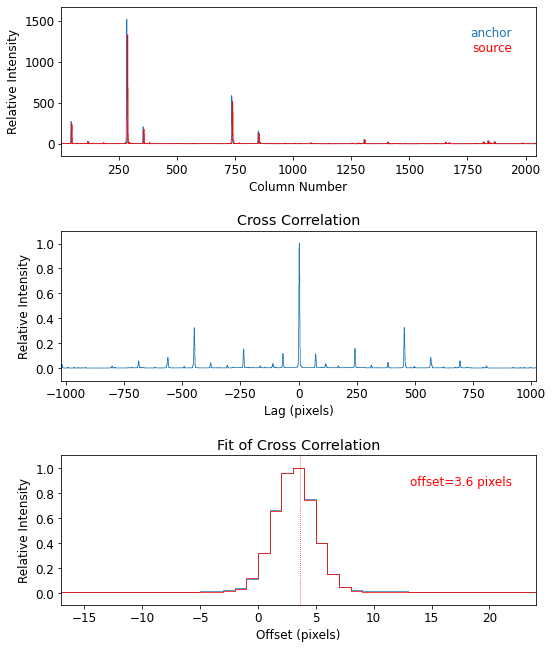

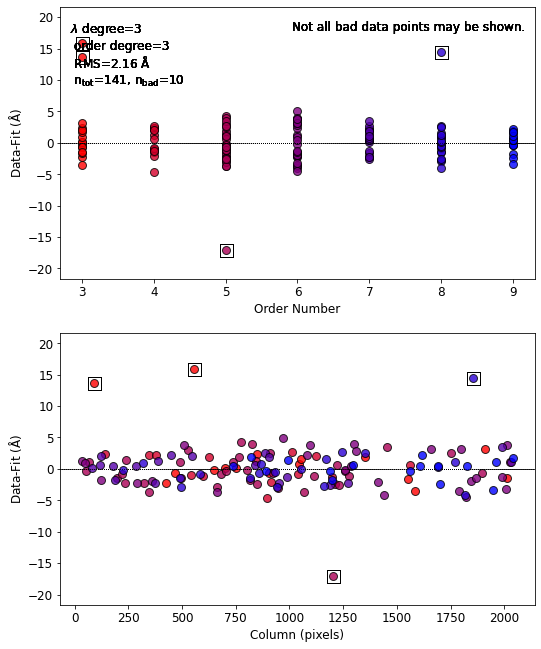

In [14]:
# Create the flat and wavecal file

# generate flat field
# note that we are using the default "flat-" prefix
ps.extract.make_flat(flat_files,'flat{}'.format(flat_files),qafile=True,prefix=flat_prefix)

# wavelength calibration
# note that we are using the default "arc-" prefix
ps.extract.make_wavecal(arc_file,'flat{}.fits'.format(flat_files),'wavecal{}'.format(arc_file),qafile_findlines=True, use_stored_solution=False,prefix=arc_prefix)


#### COMMENTS
* QA shift plot is only showing one order - can all orders be shown?
* QA residuals plot - can we get the RMS per order?, perhaps just number labels above order numbers on x-axis
* can we add a keywrod to make_wavecal that allows user to set the order?


### Point Source Extraction

In [59]:
# extraction 
ps.extract.load_image([src_files, src_prefix], 'flat{}.fits'.format(flat_files), 'wavecal{}.fits'.format(arc_files),
                      flat_field=True, linearity_correction=False, iplot=False,
                      qafile=False, reduction_mode=reduction_mode)

ps.extract.set_extraction_type(source_type)

ps.extract.make_spatial_profiles(iplot=False, qafile=False)

ps.extract.locate_aperture_positions(aperture_positions, method=aperture_method, iplot=False,
                                    qafile=False)

ps.extract.select_orders(include=orders, iplot=False, qafile=False)

ps.extract.trace_apertures(iplot=False, qafile=True)

ps.extract.define_aperture_parameters(ps_aperture, iplot=False, psf_radius=psf_radius,
                                      bg_radius=ps_bg_parameters[0], bg_width=ps_bg_parameters[1], qafile=True)

ps.extract.extract_apertures()

Loading the flat...
Loading the wavecal...
Loading the image and not correcting for non-linearity...
Flat fielding the image...
Setting extraction type to point source...
Creating the spatial profiles...
Locating the apertures...
Aperture signs are (+, -)...
Updating order selection...
Tracing apertures...


/Users/adam/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


100% |**********************************************************************|
100% |**********************************************************************|
Extracting 2 apertures in 7 orders (with background subtraction)...
100% |**********************************************************************|
Wrote spectra00001.fits to disk.
Wrote spectra00002.fits to disk.


#### COMMENTS
* should we include as QA for extract_apertures a plot of 1D extractions in each order?

### Visualize output

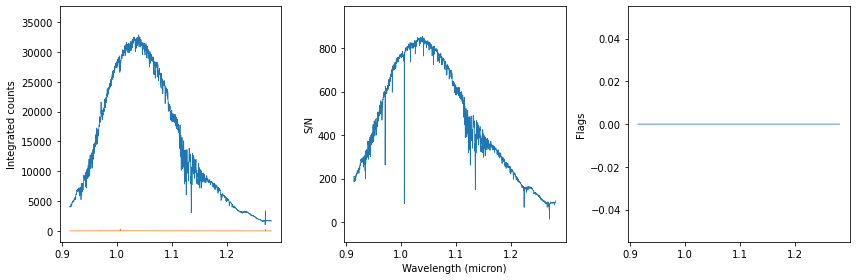

In [57]:
# check output
file = proc_path+'spectra00001.fits'
order = 6

# doing this with temporary function defined above
w,f,u,fl = tmp_read_file(file,order)
fig = plt.figure(figsize=[12,4])
ax1 = plt.subplot(131)
ax1.plot(w,f)
ax1.plot(w,u)
ax1.set_ylim([-1.,1.2]*numpy.nanquantile(f,[0.05,0.95]))
ax2.set_xlabel('Wavelength (micron)')
ax1.set_ylabel('Integrated counts')
ax2 = plt.subplot(132)
ax2.plot(w,f/u)
ax2.set_ylim([-1.,1.2]*numpy.nanquantile(f/u,[0.05,0.95]))
ax2.set_xlabel('Wavelength (micron)')
ax2.set_ylabel('S/N')
ax3 = plt.subplot(133)
ax3.plot(w,fl)
ax3.set_ylabel('Flags')
plt.tight_layout()
plt.show()


### Extended Source Extraction

In [76]:
# modify parameters
source_type = 'xs' # source type: 'ps' (default) or 'xs'
reduction_mode = 'A' # reduction mode: 'A-B' (default), 'A', 'A-Sky/Dark'
aperture_method = 'fixed' # method to identify aperture: 'fixed', 'guess', or 'auto' (default)
ps_aperture = 1.5 # preset aperture width for point source in multiples of PSF radius
psf_radius = 1.5 # point source PSF radius
ps_bg_parameters = [2.5,4] # point source background parameters; radius to start, then width

aperture_positions = [3.7,11] # extended source aperture, one per source extracted
bg_regions = [[[0.5,2.],[6,12]],[[1,9],[13,14]]] # extended source background apertures in pixels specifying left and right

# extraction - loop through each file separately
fnums = ps.io.files.extract_filestring(src_files,'index')
print(fnums)
for i,num in enumerate(fnums):
    ps.extract.load_image([str(num), src_prefix], 'flat{}.fits'.format(flat_files), 'wavecal{}.fits'.format(arc_files),
                          flat_field=True, linearity_correction=False, iplot=False,
                          qafile=False, reduction_mode=reduction_mode)

    ps.extract.set_extraction_type(source_type)

    ps.extract.make_spatial_profiles(iplot=False, qafile=False)

    ps.extract.locate_aperture_positions([aperture_positions[i]], method=aperture_method, iplot=False, qafile=False)

    ps.extract.select_orders(include=orders, iplot=False, qafile=False)

    ps.extract.trace_apertures(iplot=False, qafile=True)

    ps.extract.define_aperture_parameters(ps_aperture, bg_regions=bg_regions[i], iplot=False, qafile=True)

    ps.extract.extract_apertures(output_filenames='spectra_xs{}'.format(num))


[1, 2]
Loading the flat...
Loading the wavecal...
Loading the image and not correcting for non-linearity...
do later.
Flat fielding the image...


UnboundLocalError: local variable 'img' referenced before assignment

#### COMMENTS
* should we include as QA for extract_apertures a plot of 1D extractions in each order?

### Visualize output

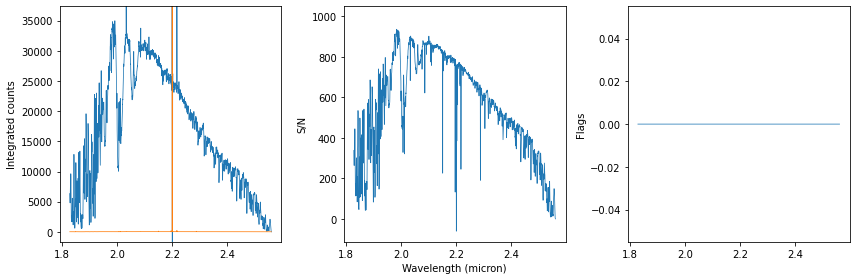

In [75]:
# check output
file = proc_path+'spectra_xs1.fits.fits'
order = 3

# doing this with temporary function defined above
w,f,u,fl = tmp_read_file(file,order,mode='A')
fig = plt.figure(figsize=[12,4])
ax1 = plt.subplot(131)
ax1.plot(w,f)
ax1.plot(w,u)
ax1.set_ylim([-1.,1.2]*numpy.nanquantile(f,[0.05,0.95]))
ax2.set_xlabel('Wavelength (micron)')
ax1.set_ylabel('Integrated counts')
ax2 = plt.subplot(132)
ax2.plot(w,f/u)
ax2.set_ylim([-1.,1.2]*numpy.nanquantile(f/u,[0.05,0.95]))
ax2.set_xlabel('Wavelength (micron)')
ax2.set_ylabel('S/N')
ax3 = plt.subplot(133)
ax3.plot(w,fl)
ax3.set_ylabel('Flags')
plt.tight_layout()
plt.show()
